# 套件引入 & 路徑設定

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne

In [3]:
import os
import sys
import mne
import numpy as np
import torch
from torchsummary import summary
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [4]:
from BCI_model_class import SCCNet, SCCNet_25s, ShallowConvNet, ShallowConvNet2, cus_EEGNet
import Dataset_training_schema as dts
import train_model as tm

In [ ]:
path_to_this_work = '/content/drive/MyDrive/fNIRS_Deeplearning_Test'
os.chdir(path_to_this_work)
os.listdir(path_to_this_work)
path_to_src = path_to_this_work + '/src_before20230712'


sys.path.insert(0, path_to_src)
os.environ['PYTHONPATH'] += (":"+path_to_src)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 自定義function

In [10]:
def get_grad(model, optimizer, data, class_idx, back):
  optimizer.zero_grad()
  images = torch.tensor(data,dtype=torch.float)
  images = images.unsqueeze(0)
  images = images.to(device)
  images.requires_grad=True
  outputs = model(images)

  if back=='output':
    outputs[0][class_idx].backward()
  elif back=='loss':
    labels=torch.zeros(3)
    labels[class_idx]=1
    loss = criterion(outputs, labels)
    loss.backward()
  img_grad = images.grad
  return img_grad

In [11]:

def plot_heatmap(table, title, center=0, vmin=None, vmax=None):
  # data = img_grad[0,1,:,:]
  data = np.array([])
  if type(table) is np.ndarray:
    data = table
  elif torch.is_tensor(table):
    data = table.cpu().detach().numpy()
  df_cm = pd.DataFrame(data, index = range(1,data.shape[0]+1))
  plt.figure(figsize = (10,6))
  plt.title(title)
  sns.heatmap(df_cm, center=center, vmin=vmin, vmax=vmax)
  plt.xlabel('time')
  plt.ylabel('channel')


In [12]:
def get_sec_avg(table, fs, abs, s_in_one=1):
  # data = img_grad[0,0,:,:]
  # abs=True
  # fs=13.3
  data = table

  # print(data.shape)
  time_point=data.shape[1]
  channel=data.shape[0]
  s_num=round(time_point/fs)
  output = np.zeros([channel, s_num])


  for i in range(0,s_num):
    # print(i,", ",round(fs*i),", ",round(fs*(i+1)))
    start = round(fs*i)
    end = round(fs*(i+1))
    sub_table = img_grad[0,0,:,start:end]
    if abs:
      sub_table = np.absolute(sub_table.cpu())
    sub_table=np.mean(sub_table.cpu().detach().numpy(),axis=1)
    output[:,i]=sub_table
    # break
  return output
  # print(output)




In [13]:
def plot_timestemp_topomap(data):
  fig, ax = plt.subplots(5,5,figsize=(10, 10),subplot_kw={'xticks': [], 'yticks': []})

  # 輸出圖，使用mne.viz.plot_topomap
  map_index = 0
  for i in range(5):
    for j in range(5):
        title_name = 's = '+str(map_index)+'~'+str(map_index+1)
        ax[i,j].set_title(title_name)
        mne.viz.plot_topomap(data=data[:,i+j],pos=position[:,0:2],axes= ax[i,j],show=False,size=5)
        map_index = map_index + 1
        # if map_index == 20:
        #   break

  plt.show()

In [14]:
class cus_EEGNet(nn.Module):
    def __init__(self,conv1_size=64, sep_conv_size=16 ,n_Hb=1, time_point=134, channel_num =20,  acti_fun='elu', pooling_type = 'avgPool', class_num = 3):
        super(cus_EEGNet, self).__init__()
        self.conv1_size = conv1_size
        self.n_Hb = n_Hb
        self.time_point = time_point+time_point%2
        self.channel_num = channel_num
        self.acti_fun = acti_fun
        self.acti_fun2 = acti_fun
        self.sep_conv_size = sep_conv_size
        self.class_num = class_num

        self.F1 = 8*self.n_Hb
        self.F2 = 16*self.n_Hb
        self.D = 2
        self.padding = int(self.conv1_size/2)
        self.n_linear = int((int(self.time_point/4)+(self.time_point/4)%2)/8)*self.n_Hb
        self.actf = nn.ELU()
        # self.pooling1 = nn.AvgPool2d((1, 4))
        # self.pooling2 = nn.AvgPool2d((1, 8))

        # if pooling_type == 'avgPool':
        #   self.pooling1 = nn.AvgPool2d((1, 4))
        #   self.pooling2 = nn.AvgPool2d((1, 8))
        # elif pooling_type == 'maxPool':
        #   self.pooling1 = nn.MaxPool2d((1, 4))
        #   self.pooling2 = nn.MaxPool2d((1, 8))

        if acti_fun == 'relu':
          self.actf = nn.ReLU()

        self.conv1 = nn.Sequential(
            nn.Conv2d(self.n_Hb, self.F1, (1, self.conv1_size), padding=(0, self.padding), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2_1 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (self.channel_num, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1)
        )
        # self.conv2_2 = nn.Sequential(
        #     # nn.AvgPool2d((1,4)),
        #     self.pooling1,
        #     nn.Dropout(0.5)
        # )
        # self.pooling1
        self.dropout = nn.Dropout(0.5)
        self.Conv3_1 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, self.sep_conv_size), padding=(0, int(self.sep_conv_size/2)), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2)
        )
        # self.Conv3_2 = nn.Sequential(
        #     # nn.AvgPool2d((1, 8)),
        #     self.pooling2,
        #     nn.Dropout(0.5)
        # )

        self.classifier = nn.Linear(16*self.n_linear, self.class_num, bias=True)

    def activation_Fun(self,x,act_n):
        if self.acti_fun == 'relu' or self.acti_fun == 'elu':
          x = self.actf(x)
        elif self.acti_fun == 'square' or \
        self.acti_fun == 'square12' or \
        (self.acti_fun == 'square1' and act_n==1) or \
        (self.acti_fun == 'square2' and act_n==2):
          # print('square')
          x = x**2
        elif self.acti_fun == 'linear':
          # print('linear')
          x=x
        else :
          x = self.actf(x)
        return x

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_1(x)
        x = self.activation_Fun(x,1)
        # x = self.pooling1(x)
        x = nn.AvgPool2d((1,4))
        x = self.dropout(x)
        # x = self.conv2_2(x)
        x = self.Conv3_1(x)
        x = self.activation_Fun(x,2)
        x = nn.AvgPool2d((1,8))
        # x = self.pooling2(x)
        x = self.dropout(x)
        # x = self.Conv3_2(x)
        x = x.view(-1, 16*self.n_linear)
        x = self.classifier(x)
        # x = self.softmax(x)
        return x


In [6]:
class parameter:
    def __init__(self, architecture, batch_size, kernel_size, learning_rate, weight_decay):
        self.architecture = architecture
        self.batch_size = batch_size
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
parameter_set={
  'SCCNet_h1' : parameter('SCCNet',64,134,0.001,0.00001),
  'SCCNet_h2' : parameter('SCCNet',16,6,0.01,0.00001),
  'SCCNet_h3' : parameter('SCCNet',32,12,0.01,0.00001),
  'EEGNet_h1' : parameter('EEGNet',16,32,0.001,0.001),
  'EEGNet_h2' : parameter('EEGNet',32,134,0.001,0.0001),
  'EEGNet_h3' : parameter('EEGNet',32,24,0.001,0.0001),
  'EEGNet_h4' : parameter('EEGNet',64,64,0.001,0.0001)
}

In [7]:
dataset='preprocess'
duration='25s'
parameter_tag='EEGNet_h1'
scheme='SD'
channel_num =20
sub=15

path_dataset='./dataset/'+ dataset + '_' + duration + '/'
s1=path_dataset+'S'
s2='.mat'

p = parameter_set[parameter_tag]
architecture = p.architecture
batch_size = p.batch_size
kernel_size = p.kernel_size
learning_rate = p.learning_rate
weight_decay = p.weight_decay


if scheme == 'SI':
  test_HbO, test_HbR, test_HbT, test_labels, train_HbO, train_HbR, train_HbT, train_labels = dts.leave_subject_out(s1,s2, data_range=range(1,31), test_id=int(sub))
elif scheme == 'SD':
  range1 = list(range(0,25,1))
  range2 = list(range(25,75,1))
  test_HbO, test_HbR, test_HbT, test_labels, train_HbO, train_HbR, train_HbT, train_labels = dts.leave_trial_out(s1, s2, int(sub), range1, range2)

Hb_test = np.concatenate((np.expand_dims(test_HbO,1), np.expand_dims(test_HbR,1)), axis=1)
Hb_train = np.concatenate((np.expand_dims(train_HbO,1), np.expand_dims(train_HbR,1)), axis=1)
train_loader = dts.getDataLoader(Hb_train, train_labels, batch_size=32, onehot_encoding=False)
test_loader = dts.getDataLoader(Hb_test, test_labels, batch_size=32, onehot_encoding=False)
# train_loader = dts.getDataLoader(Hb_train, train_labels, batch_size=32, onehot_encoding=False, shuffle=True)
# test_loader = dts.getDataLoader(Hb_test, test_labels, batch_size=32, onehot_encoding=False, shuffle=False)

leave trial 25 out
training data dimension:  (50, 20, 334)
training label dimension:  (50, 3)
testing data dimension:  (25, 20, 334)
testing label dimension:  (25, 3)


In [8]:
electrode=list(['Ch01','Ch02','Ch03','Ch04','Ch05','Ch06','Ch07','Ch08','Ch09','Ch10','Ch11','Ch12','Ch13','Ch14','Ch15','Ch16','Ch17','Ch18','Ch19','Ch20'])
my_montage={
  'Ch01':np.array([-0.03474375,0.0703499,0.04301775]),
  'Ch02':np.array([-0.0502438,0.0531112,0.042192]),
  'Ch03':np.array([-0.0274958,0.0569311,0.060342]),
  'Ch04':np.array([-0.04299585,0.0396924,0.05951625]),
  'Ch05':np.array([-0.0601819,0.0227162,0.055544]),
  'Ch06':np.array([-0.0340619,0.0260111,0.079987]),
  'Ch07':np.array([-0.048939975,0.006777925,0.07241025]),
  'Ch08':np.array([-0.0653581,-0.0116317,0.064358]),
  'Ch09':np.array([-0.036158,-0.0099839,0.089752]),
  'Ch10':np.array([-0.052576125,-0.028393525,0.08169975]),
  'Ch11':np.array([0.0367435,0.07138985,0.041656]),
  'Ch12':np.array([0.0295142,0.0576019,0.05954]),
  'Ch13':np.array([0.0518362,0.0543048,0.040814]),
  'Ch14':np.array([0.0446069,0.04051685,0.058698]),
  'Ch15':np.array([0.0347841,0.0264379,0.078808]),
  'Ch16':np.array([0.0622931,0.0237228,0.05563]),
  'Ch17':np.array([0.050466775,0.007409075,0.0716075]),
  'Ch18':np.array([0.037672,-0.0096241,0.088412]),
  'Ch19':np.array([0.0671179,-0.0109003,0.06358]),
  'Ch20':np.array([0.054323125,-0.027933475,0.0803845]),
}

In [9]:
position= [my_montage[i] for i in electrode]
position= np.asarray(position)


In [18]:
  # 取得subject平均
test_class = np.where(test_labels == 1)[1]
train_class = np.where(train_labels == 1)[1]

test_class0_ind = np.where(test_class==0)
test_class1_ind = np.where(test_class==1)
test_class2_ind = np.where(test_class==2)

train_class0_ind = np.where(train_class==0)
train_class1_ind = np.where(train_class==1)
train_class2_ind = np.where(train_class==2)


data0 = np.concatenate((Hb_test[test_class0_ind,:,:,:].squeeze(0), Hb_train[train_class0_ind,:,:,:].squeeze(0)), axis=0)
data1 = np.concatenate((Hb_test[test_class1_ind,:,:,:].squeeze(0), Hb_train[train_class1_ind,:,:,:].squeeze(0)), axis=0)
data2 = np.concatenate((Hb_test[test_class2_ind,:,:,:].squeeze(0), Hb_train[train_class2_ind,:,:,:].squeeze(0)), axis=0)

data0 = np.mean(data0,axis=0)
data1 = np.mean(data1,axis=0)
data2 = np.mean(data2,axis=0)


# 預訓練的模型引入

In [ ]:
model = torch.load('/content/drive/MyDrive/fNIRS_Deeplearning_Test/sub15_EEGNet.pth')
model.eval()

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-3, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# 熱力圖

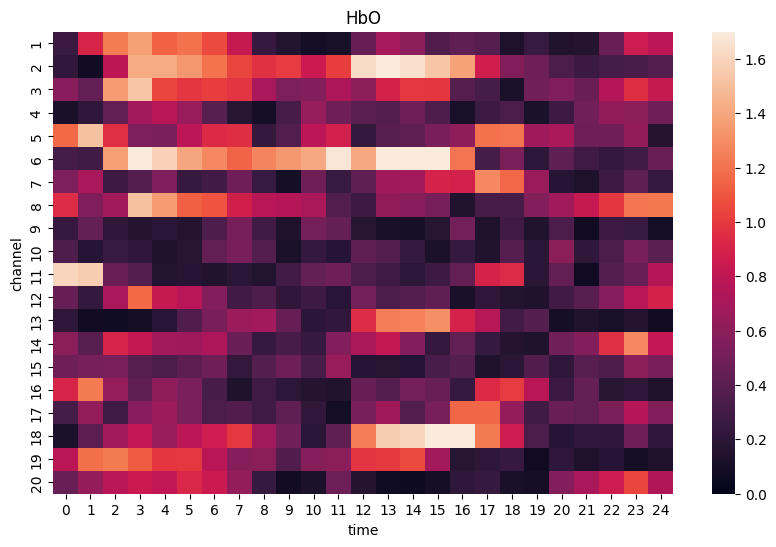

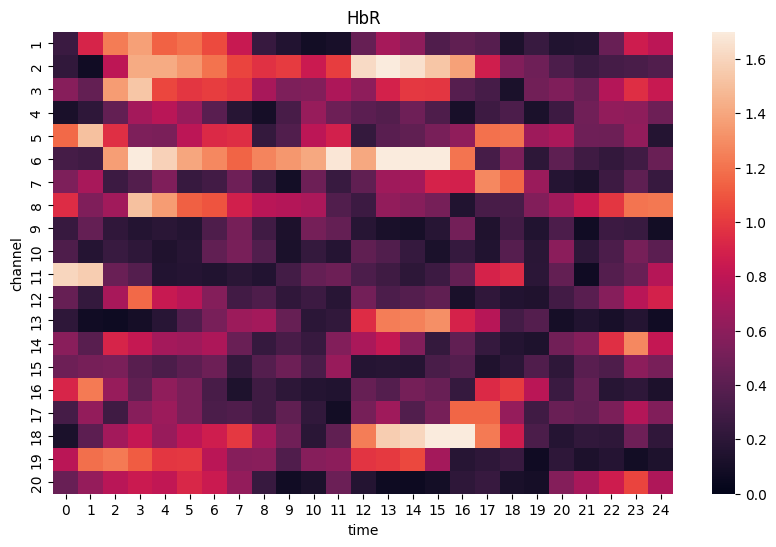

In [19]:
input_data = data0
class_id = 0


img_grad = get_grad(model, optimizer, data=input_data, class_idx=class_id, back='output')


data = get_sec_avg(img_grad[0,0,:,:], 13.3, abs = True)
plot_heatmap(data,'HbO',None,0,1.7)
data = get_sec_avg(img_grad[0,1,:,:], 13.3, abs = True)
plot_heatmap(data,'HbR',None,0,1.7)



# 大腦地形圖

HbO


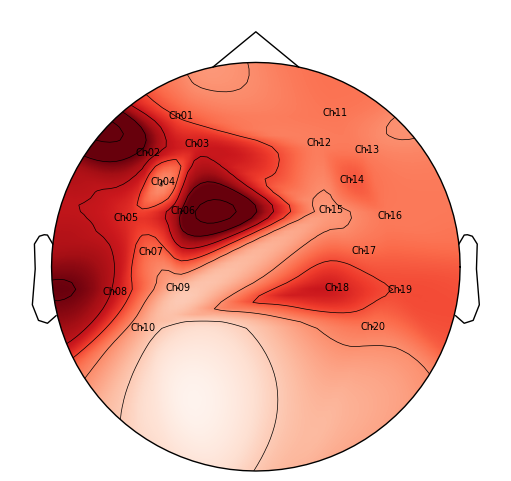

HbR


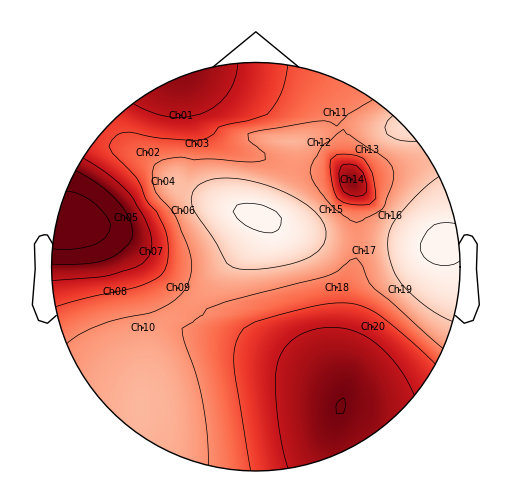

(<matplotlib.image.AxesImage at 0x7bfa2b1ee1d0>,
 <matplotlib.contour.QuadContourSet at 0x7bfa2b1ee890>)

In [20]:
input_data = data0
class_id = 0


img_grad = get_grad(model, optimizer, data=input_data, class_idx=class_id, back='output')
HbO = np.mean(np.absolute(img_grad[0,0,:,:].cpu().detach().numpy()),axis=1)
HbR = np.mean(np.absolute(img_grad[0,1,:,:].cpu().detach().numpy()),axis=1)

# fig,(ax1,ax2) = plt.subplots(ncols=2)
print('HbO')
mne.viz.plot_topomap(data=HbO,pos=position[:,0:2],show=True,size=5,names=electrode)
print('HbR')
mne.viz.plot_topomap(data=HbR,pos=position[:,0:2],show=True,size=5,names=electrode)

